삽관/발관 데이터 페어링하고 환자군 분류하는거

In [3]:
import pandas as pd
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path


# 현재 노트북 파일의 상위 디렉토리에 있는 src 디렉토리의 경로를 sys.path에 추가
module_path = Path('../src').resolve()
if module_path not in sys.path:
    sys.path.append(str(module_path))

# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls
import src.utils.utils as util   # 기타 유틸리티 모듈

### 1. 데이터 준비

In [4]:
# 데이터 불러오기
adults_icu = pd.read_csv('./data/adults_icu.csv')
intubation_extubation = pd.read_csv('./data/intubation_extubation.csv')

# 시간변수 변환
time_cols = ['intubationtime', 'extubationtime', 'admittime', 'dischtime', 'deathtime']
intubation_extubation = util.to_datetime(intubation_extubation, time_cols)

print(f'adults_icu: {adults_icu.shape}')   # (73181, 13)
print(f'intubation_extubation: {intubation_extubation.shape}')   # (10992, 14)


Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted admittime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
adults_icu: (73181, 13)
intubation_extubation: (10992, 14)


### 2. intubation, extubation 페어링
- hadm_id 별로 그룹화하여 작업. 
- 한 hadm_id에 복수의 삽관 발관이 존재할 경우 페어링 로직 적용. (main_pairing) 
- 페어링이 이루어진 후에, 행마다 관련 변수들이 같이 따라와줘야함. (reformat_paired_data_to_dataframe)
    - 참고: 페어링이 다 이루어진 후에, 삽관시간과 발관시간이 동일한 데이터가 5개 확인되어 삭제함 (1월27일 논의사항 노션 참고)

In [5]:
def pair_data(df):
    start_time = time.time()   # 소요시간 계산
    
    # subject_id와 hadm_id로 그룹화
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    single_row_list = []
    reformatted_paired_dataframe_list = []

    # 데이터 1차 정리: single row processing, multirow pairing & reformatting
    for (subject_id, hadm_id), group in tqdm(grouped_df, desc="Pairing data..."):

        # single row processing
        # 해당 그룹(hadm_id)에 intubation 이벤트가 하나만 있는 경우 (즉, 페어링이 필요 없는 경우)
        if group['intubationtime'].count() == 1:
            # inttime, exttime 만 검증 후 데이터 통과
            time_mismatch = pairing.validate_single_rows(group)   # True 일 경우 통과. False일 경우 삭제
            if not time_mismatch:
                single_row_list.append(group)   # bypass single row event

        # 해당 그룹(hadm_id) 안에 여러 개의 intubation 이벤트가 있는 경우 (즉, 페어링이 필요한 경우)
        elif group['intubationtime'].count() > 1:
            # (subject_id, hadm_id) 그룹 내에서 고유한 intubationtime, extubationtime 값 추출
            unique_intubations = list(group['intubationtime'].dropna().unique())
            unique_extubations = list(group['extubationtime'].dropna().unique())

            pairs = pairing.main_pairing(unique_intubations, unique_extubations)   # 페어링 함수 적용

            # 페어링 완료 후 데이터 재구조화 (필요한 칼럼 가져오기)
            reformatted_paired_dataframe = pairing.reformat_paired_data_to_dataframe(group, pairs, subject_id, hadm_id)
            reformatted_paired_dataframe_list.append(reformatted_paired_dataframe)

    # 데이터프레임 결합하기
    combined_list = single_row_list + reformatted_paired_dataframe_list

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)  
        combined_df = pd.concat(combined_list, ignore_index=True)

    # 'subject_id', 'hadm_id', 'imputationtime' 순으로 정렬 (ascending=True)
    combined_df = combined_df.sort_values(by=['subject_id', 'hadm_id', 'intubationtime', 'extubationtime'], ascending=True)
    combined_df = combined_df.reset_index(drop=True)

    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))

    return combined_df

In [6]:
paired_df = pair_data(intubation_extubation)
paired_df = paired_df[paired_df.intubationtime != paired_df.extubationtime]  # 오류 데이터 삭제 (상기 markdown, 노션 2024.01.27 논의사항 참고)

print(f'Processed paired_df: {paired_df.shape}')   # (9003, 15)
paired_df.columns

Pairing data...: 100%|██████████| 7087/7087 [00:09<00:00, 766.52it/s]


--- RUNTIME: 12.50 seconds ---
Processed paired_df: (9003, 15)


Index(['subject_id', 'hadm_id', 'int_stayid', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker'],
      dtype='object')

In [7]:
# 데이터 저장
paired_df.to_csv('./data/paired_df.csv')

### 3. reintubationtime  관련 변수들 계산, 데이터 정리

In [8]:
# # 데이터 reimport 할 경우 시간변수 변환 필요
# # 데이터 임포트
# paired_df = pd.read_csv('./data/paired_df.csv', index_col=0)

# time_cols = ['intubationtime', 'extubationtime', 'admittime', 'dischtime', 'deathtime']
# paired_df = util.to_datetime(paired_df, time_cols)
# print(paired_df.shape)   # (9003, 15)

In [9]:
def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, intext_duration, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.sort_ventilation_sequence(patient_df)   # 삽관/발관 시간 페어링
            patient_df = rnt.get_intext_duration(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['subject_id', 'hadm_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [10]:
reintubation_df = get_reintubation(paired_df)
print(f'Processed reintubation_df: {reintubation_df.shape}')   # (9003, 20)
reintubation_df.columns

Fetching reintubation data...: 100%|██████████| 6694/6694 [00:33<00:00, 197.46it/s]


--- RUNTIME: 35.48 seconds ---
Processed reintubation_df: (9003, 20)


Index(['subject_id', 'hadm_id', 'int_stayid', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker', 'reint_marker', 'intext_duration', 'reintubation_eventtime',
       'reintubationtime', 'seq_num'],
      dtype='object')

In [11]:
# 데이터 저장
reintubation_df.to_csv('./data/reintubation_df.csv')

### 4. 결측치 처리
- 일단 결측치는 제거하거나 대체하지 않고 최대한 가져가기로 했음. 그러나, 최종 발관시간이 NULL인 케이스만 제한적으로 deathtime, dischtime을 이용해 대체하기로 논의함. 이는 삽관시간과 발관시간의 차이값을 (mv 걸러내기 위함) 최대한 확보하기 위함.

In [12]:
# 데이터 임포트
reintubation_df = pd.read_csv('./data/reintubation_df.csv', index_col=0)

# 시간변수 변환
time_cols = ['intubationtime', 'extubationtime', 'admittime', 'dischtime', 'deathtime']
reintubation_df = util.to_datetime(reintubation_df, time_cols)

print(reintubation_df.shape)   # (9003, 20)

Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted admittime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
(9003, 20)


In [13]:
def impute_null(df):
    start_time = time.time()   # 소요시간 계산

    df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Processing null data..."):

            patient_df = imp.impute_final_extubation(patient_df)   # 최종 발관시간이 NULL인 경우 deathtime 또는 dischtime으로 대체
            patient_df = rnt.get_intext_duration(patient_df)   # 삽관시간과 발관시간의 차이 다시 계산

            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [14]:
reintubation_df2 = impute_null(reintubation_df)
print(f'Processed reintubation_df2: {reintubation_df2.shape}')   # (9003, 20)
reintubation_df2.columns

Processing null data...: 100%|██████████| 6694/6694 [00:06<00:00, 1067.72it/s]


--- RUNTIME: 8.81 seconds ---
Processed reintubation_df2: (9003, 20)


Index(['subject_id', 'hadm_id', 'int_stayid', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker', 'reint_marker', 'intext_duration', 'reintubation_eventtime',
       'reintubationtime', 'seq_num'],
      dtype='object')

In [16]:
# 데이터 저장
reintubation_df2.to_csv('./data/reintubation_df2.csv')

### 5. 환자군 분류 (ext failure, non-failure, etc.)
- subjectlist1: mvtime 제거 안한 버전
- subjectlist2: mvtime 제거 한 버전

#### 분류 코드

11    재삽관 없이 발관후 48시간 넘어 퇴원 | nonfailure

121   재삽관 없이 발관후 48시간 이내 사망 X | nonfailure

1221  재삽관 없이 발관후 24시간 이내 사망 | death

1222  재삽관 없이 발관후 24~48시간 이내 사망 | death

211   48시간 이내 재삽관 | failure

212   48시간 너머 재삽관 | nonfailure

221   최종 발관 이후 48시간 넘어 퇴원 | nonfailure

2221  최종 발관 이후 48시간 이내 사망 X | nonfailure

22221 최종 발관 이후 24시간 이내 사망 | death

22222 최종 발관 이후 24~48시간 이내 사망 | death

999   (null case)현발관-다음발관이 48시간 이내 | Failure

998   (null case)현삽관-다음삽관이 48시간 이내 | Failure

9999  (null case) non-failure 판단 불가 | 제거

In [17]:
# 데이터 임포트
reintubation_df2 = pd.read_csv('./data/reintubation_df2.csv', index_col=0)

# 시간변수 변환
time_cols = ['intubationtime', 'extubationtime', 'admittime', 'dischtime', 'deathtime']
reintubation_df2 = util.to_datetime(reintubation_df2, time_cols)

print(reintubation_df2.shape)   # (9003, 20)

Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted admittime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
(9003, 20)


In [18]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [19]:
subjectlist1 = categorize_patients(reintubation_df2)
subjectlist2 = subjectlist1[subjectlist1.mvtime == False]   # mvtime 제거

print(f'Processed subjectlist1: {subjectlist1.shape}')   # (9003, 27)
print(f'Processed subjectlist2: {subjectlist2.shape}')   # (6823, 27)

subjectlist1.columns

Categorizing extubation failure vs non-failure...: 100%|██████████| 6694/6694 [00:29<00:00, 226.36it/s]


--- RUNTIME: 32.77 seconds ---
Processed subjectlist1: (9003, 27)
Processed subjectlist2: (6823, 27)


Index(['subject_id', 'hadm_id', 'int_stayid', 'admittime', 'intubationtime',
       'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
       'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime', 'deathtime',
       'marker', 'reint_marker', 'intext_duration', 'reintubation_eventtime',
       'reintubationtime', 'seq_num', 'mvtime', 'final_event', 'ext_to_death',
       'ext_to_disch', 'disch_to_death', 'class_code', 'class'],
      dtype='object')

In [20]:
# 저장
subjectlist1.to_csv('./data/subjectlist1.csv')
subjectlist2.to_csv('./data/subjectlist2.csv')

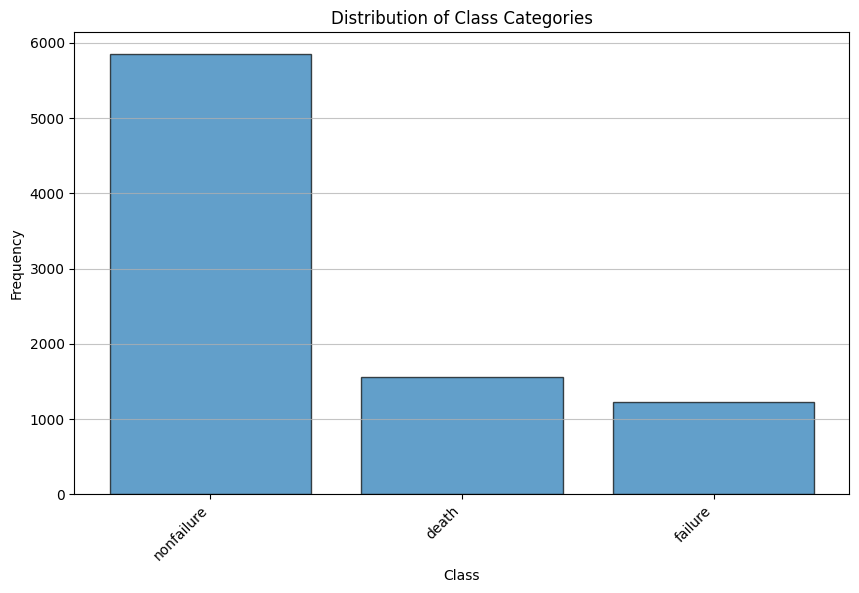

In [21]:
# Count the occurrences of each class
class_counts = subjectlist1['class'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()